In [0]:
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Sequential
from keras.models import Model
from keras import regularizers
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [10]:
!wget https://github.com/iceman67/HRS/blob/master/April_sensor_data.csv

--2020-05-10 06:49:35--  https://github.com/iceman67/HRS/blob/master/April_sensor_data.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘April_sensor_data.csv.1’

April_sensor_data.c     [ <=>                ]  63.99K  --.-KB/s    in 0.03s   

2020-05-10 06:49:35 (2.06 MB/s) - ‘April_sensor_data.csv.1’ saved [65530]



In [0]:
# read in that strange European CSV data, semi-colon separated, with commas for decimal points
aqdf = pd.read_csv("April_sensor_data.csv")

In [12]:
aqdf.columns

Index(['NO', 'REG_DATE', 'PM2.5', 'PM10.0', 'Temperature', 'Huminity', 'TVOC',
       'CO2'],
      dtype='object')

In [0]:
aqdf = aqdf.rename(columns={'Huminity': 'Humidity', 'PM2.5' :'PM25', 'PM10.0':'PM100'})

In [0]:
aqdf.drop('NO', axis=1, inplace=True)
aqdf.drop('REG_DATE', axis=1, inplace=True)
#aqdf.drop('PM2.5', axis=1, inplace=True)
#aqdf.drop('PM10.0', axis=1, inplace=True)
aqdf.drop('Temperature', axis=1, inplace=True)
aqdf.drop('TVOC', axis=1, inplace=True)
aqdf.drop('Humidity', axis=1, inplace=True)
aqdf.drop('CO2', axis=1, inplace=True)


The standard score of a sample x is calculated as:

z = (x - u) / s

Standardization of a dataset is a common requirement for many machine learning estimators.  

StandardScaler(x), 평균이 0과 표준편차가 1이 되도록 변환

https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/


In [0]:
#scaler =MinMaxScaler()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(aqdf)

In [0]:
x_means = scaler.mean_
x_stds = scaler.scale_

In [17]:
x_means

array([13.8635544, 13.8726821])

In [18]:
x_stds

array([8.07562686, 7.59808376])

In [19]:
x_scaled[0]

array([-0.78304192, -1.01113417])

In [20]:
x_scaled.shape

(25920, 2)

In [0]:
y = x_scaled[:, 0]                  # y is  CO2 column - the target

In [22]:
y

array([-0.78304192, -0.7471314 , -0.78304192, ..., -1.08890053,
       -1.23378093, -1.14214717])

In [0]:
x = np.delete(x_scaled, 0, axis=1)  # x is everything else - the input

In [24]:
x.shape

(25920, 1)

In [25]:
x_stds[0]

8.075626862954957

In [26]:
x_means[0]

13.863554398148148

In [0]:
train_size = int(0.7 * x.shape[0])

In [0]:
x_train, x_test, y_train, y_test = x[0:train_size], x[train_size:], y[0:train_size], y[train_size:]

In [0]:
# regression network with 1 features -> 8 latent space -> 1 output

readings = Input(shape=(1, ))
encoded = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(readings)
decoded = Dense(1, kernel_initializer='glorot_uniform')(encoded)
model = Model(inputs=[readings], outputs=[decoded])

model.compile(loss='mse', optimizer='adam')

In [33]:
my_epochs = 50

my_batch_size = 10
history = model.fit(x_train, y_train, batch_size=my_batch_size, epochs=my_epochs, validation_split=0.2)
y_test_pred = model.predict(x_test).flatten()

# Look at the results
restore_PM25 = lambda m: (m * x_stds[0]) + x_means[0]

for i in range(10):
    label = restore_PM25(y_test[i])
    prediction = restore_PM25(y_test_pred[i])
    print("PM 2.5 expected: {:.3f}, predicted: {:.3f}".format(label, prediction))



Train on 14515 samples, validate on 3629 samples
Epoch 1/50
14515/14515 [==============================] - 1s 103us/step - loss: 0.0503 - val_loss: 0.0434
Epoch 2/50
14515/14515 [==============================] - 2s 104us/step - loss: 0.0503 - val_loss: 0.0448
Epoch 3/50
14515/14515 [==============================] - 1s 103us/step - loss: 0.0503 - val_loss: 0.0450
Epoch 4/50
14515/14515 [==============================] - 2s 104us/step - loss: 0.0503 - val_loss: 0.0450
Epoch 5/50
14515/14515 [==============================] - 2s 105us/step - loss: 0.0503 - val_loss: 0.0445
Epoch 6/50
14515/14515 [==============================] - 2s 106us/step - loss: 0.0503 - val_loss: 0.0452
Epoch 7/50
14515/14515 [==============================] - 2s 106us/step - loss: 0.0503 - val_loss: 0.0438
Epoch 8/50
14515/14515 [==============================] - 2s 104us/step - loss: 0.0503 - val_loss: 0.0444
Epoch 9/50
14515/14515 [==============================] - 1s 102us/step - loss: 0.0503 - val_loss: 0.04

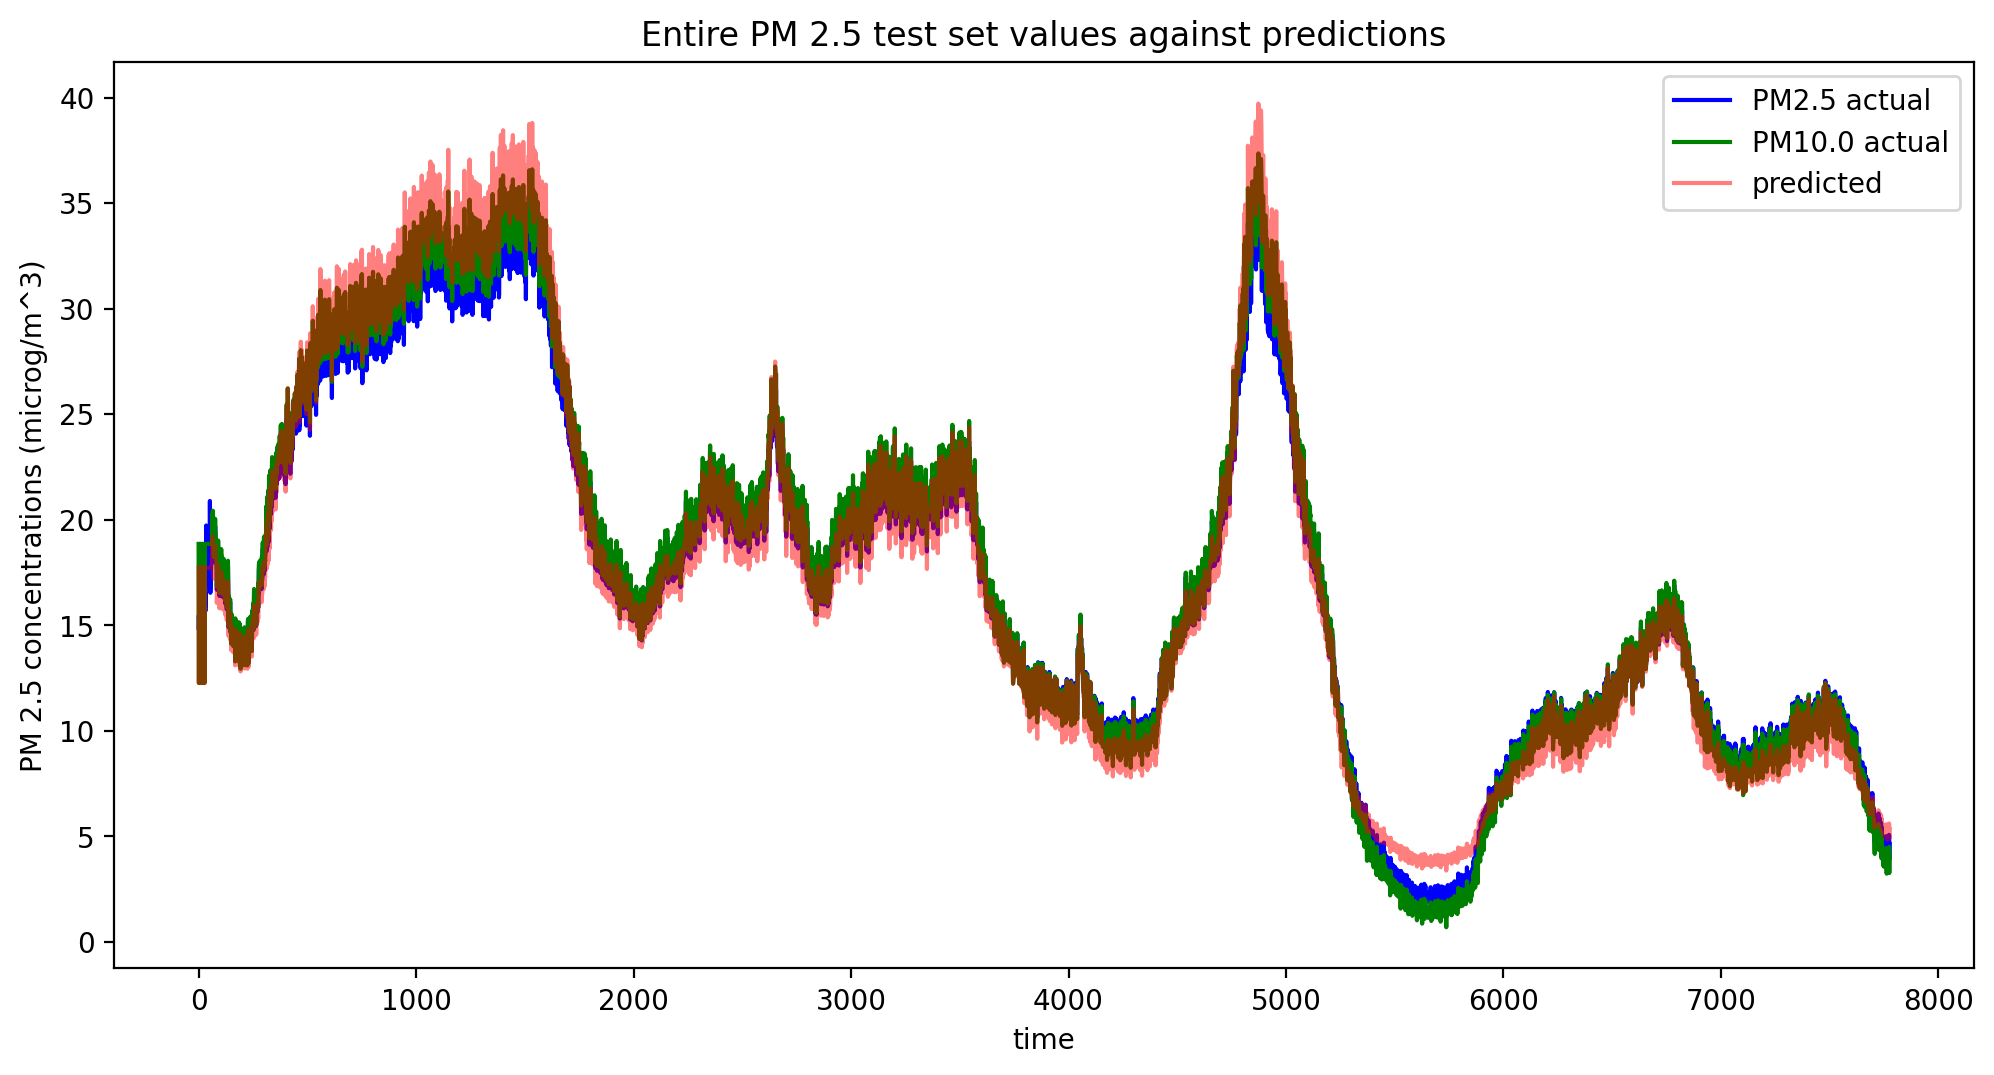

In [34]:
plt.figure(figsize=(12, 6), dpi=200)
plt.title("Entire PM 2.5 test set values against predictions")
plt.plot(np.arange(y_test.shape[0]), restore_PM25(y_test), color='b', label='PM2.5 actual')
plt.plot(np.arange(x_test.shape[0]), restore_PM25(x_test), color='g', label='PM10.0 actual')
#plt.plot(np.arange(x_test.shape[0]), x_test, color='g', label='Humity actual')
plt.plot(np.arange(y_test_pred.shape[0]), restore_PM25(y_test_pred), color='r', alpha=0.5, label='predicted')
plt.xlabel("time")
plt.ylabel("PM 2.5 concentrations (microg/m^3)")
plt.legend(loc='best')
plt.show()


K.clear_session()

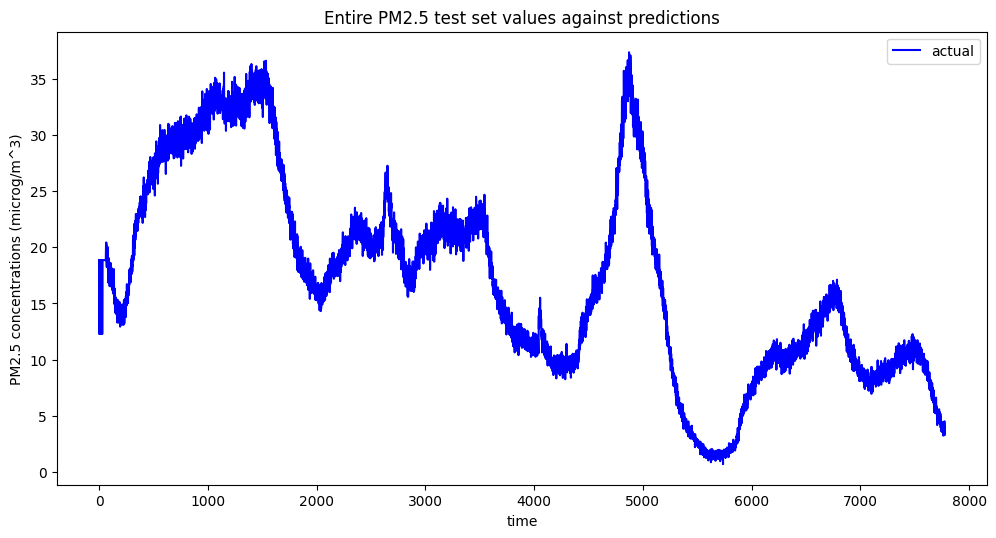

In [35]:
plt.figure(figsize=(12, 6), dpi=100)
plt.title("Entire PM2.5 test set values against predictions")
plt.plot(np.arange(x_test.shape[0]), restore_benzine(x_test), color='b', label='actual')
plt.xlabel("time")
plt.ylabel("PM2.5 concentrations (microg/m^3)")
plt.legend(loc='best')
plt.show()